##### From https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8

In [1]:
import string
import re
import contractions

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup
from textblob import TextBlob
from unidecode import unidecode

def lemmatize_pos_tagged_text(text, lemmatizer, pos_tag_dict):
  sentences = nltk.sent_tokenize(text)
  new_sentences = []

  for sentence in sentences:
    sentence = sentence.lower()
    new_sentence_words = []    #one pos_tuple for sentence
    pos_tuples = nltk.pos_tag(nltk.word_tokenize(sentence)) 

    for word_idx, word in enumerate(nltk.word_tokenize(sentence)):
      nltk_word_pos = pos_tuples[word_idx][1]
      wordnet_word_pos = pos_tag_dict.get(
                          nltk_word_pos[0].upper(), None)
      if wordnet_word_pos is not None:
        new_word = lemmatizer.lemmatize(word, wordnet_word_pos)
      else:
        new_word = lemmatizer.lemmatize(word)

      new_sentence_words.append(new_word)

    new_sentence = " ".join(new_sentence_words)
    new_sentences.append(new_sentence)

  return " ".join(new_sentences)

In [2]:
def download_if_non_existent(res_path, res_name):
  try:
    nltk.data.find(res_path)
  except LookupError:
    print(f'resource {res_path} not found. Downloading now...')
    nltk.download(res_name)

class NltkPreprocessingSteps:
  def __init__(self, X):
    self.X = X
    download_if_non_existent('corpora/stopwords', 'stopwords')
    download_if_non_existent('tokenizers/punkt', 'punkt')
    download_if_non_existent('taggers/averaged_perceptron_tagger',
                             'averaged_perceptron_tagger')
    download_if_non_existent('corpora/wordnet', 'wordnet')
    download_if_non_existent('corpora/omw-1.4', 'omw-1.4')

    self.sw_nltk = stopwords.words('english')
    new_stopwords = ['<*>']
    self.sw_nltk.extend(new_stopwords)
    self.sw_nltk.remove('not')

    self.pos_tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

    # '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~' 32 punctuations in python
    # we dont want to replace . first time around
    self.remove_punctuations = string.punctuation.replace('.','')

  def remove_html_tags(self):
    self.X = self.X.apply(
            lambda x: BeautifulSoup(x, 'html.parser').get_text())
    return self

  def replace_diacritics(self):
    self.X = self.X.apply(
            lambda x: unidecode(x, errors="preserve"))
    return self

  def to_lower(self):
    self.X = np.apply_along_axis(lambda x: x.lower(), self.X)
    return self

  def expand_contractions(self):
    self.X = self.X.apply(
            lambda x: " ".join([contractions.fix(expanded_word) 
                        for expanded_word in x.split()]))
    return self

  def remove_numbers(self):
    self.X = self.X.apply(lambda x: re.sub(r'\d+', '', x))
    return self

  def replace_dots_with_spaces(self):
    self.X = self.X.apply(lambda x: re.sub("[.]", " ", x))
    return self

  def remove_punctuations_except_periods(self):
    self.X = self.X.apply(
                 lambda x: re.sub('[%s]' %
                  re.escape(self.remove_punctuations), '' , x))
    return self

  def remove_all_punctuations(self):
    self.X = self.X.apply(lambda x: re.sub('[%s]' %
                          re.escape(string.punctuation), '' , x))
    return self

  def remove_double_spaces(self):
    self.X = self.X.apply(lambda x: re.sub(' +', ' ', x))
    return self

  def fix_typos(self):
    self.X = self.X.apply(lambda x: str(TextBlob(x).correct()))
    return self

  def remove_stopwords(self):
    # remove stop words from token list in each column
    self.X = self.X.apply(
            lambda x: " ".join([ word for word in x.split() 
                     if word not in self.sw_nltk]) )
    return self

  def lemmatize(self):
    lemmatizer = WordNetLemmatizer()
    self.X = self.X.apply(lambda x: lemmatize_pos_tagged_text(
                           x, lemmatizer, self.pos_tag_dict))
    return self

  def get_processed_text(self):
    return self.X

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
dataset = pd.read_csv("Restaurant_Reviews.tsv", sep="\t", quoting=3)
y = dataset['Liked'].values

In [4]:
X = \
    NltkPreprocessingSteps(dataset['Review'])\
    .remove_html_tags()\
    .replace_diacritics()\
    .expand_contractions()\
    .remove_numbers()\
    .fix_typos()\
    .remove_punctuations_except_periods()\
    .lemmatize()\
    .remove_double_spaces()\
    .remove_all_punctuations()\
    .remove_stopwords()\
    .get_processed_text()

resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/hamdouni-e/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/hamdouni-e/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/tmp/ipykernel_307/3084143451.py:34: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  lambda x: BeautifulSoup(x, 'html.parser').get_text())


In [49]:
ngram_range = (1,2)
max_features = 1000

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    max_features=max_features, ngram_range=ngram_range,
    min_df=0.002,  max_df=0.5
)

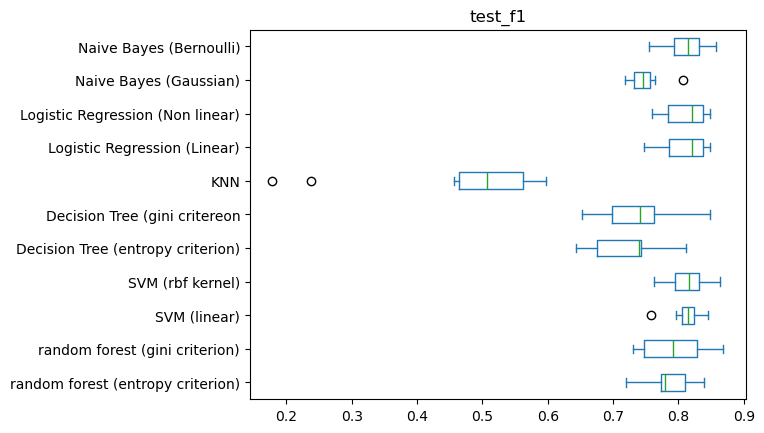

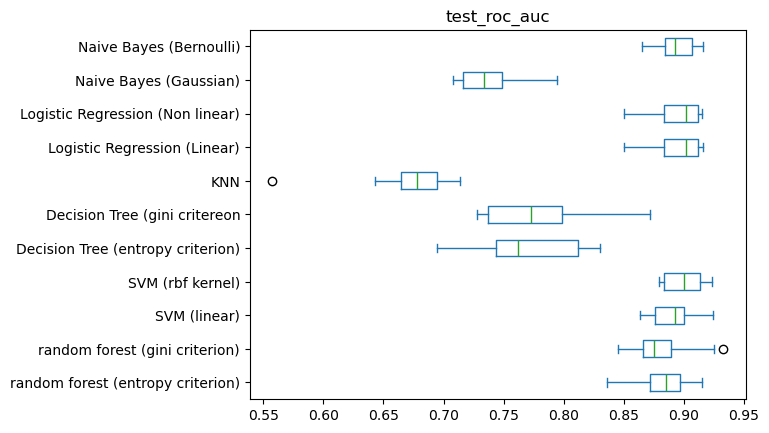

In [51]:
classifiers = {}

from sklearn.ensemble import RandomForestClassifier
classifiers['random forest (entropy criterion)'] = RandomForestClassifier(criterion="entropy", n_estimators=100)
classifiers['random forest (gini criterion)'] = RandomForestClassifier(criterion="gini", n_estimators=100)

from sklearn.svm import SVC
classifiers['SVM (linear)'] = SVC(kernel = 'linear')
classifiers['SVM (rbf kernel)'] = SVC(kernel = 'rbf')

from sklearn.tree import DecisionTreeClassifier, 
classifiers['Decision Tree (entropy criterion)'] = DecisionTreeClassifier(criterion = 'entropy')
classifiers['Decision Tree (gini critereon'] = DecisionTreeClassifier(criterion = 'gini')

from sklearn.neighbors import KNeighborsClassifier
classifiers['KNN'] = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

from sklearn.linear_model import LogisticRegression
classifiers['Logistic Regression (Linear)'] = LogisticRegression(solver='liblinear')
classifiers['Logistic Regression (Non linear)'] = LogisticRegression(solver='lbfgs')

from sklearn.naive_bayes import GaussianNB
classifiers['Naive Bayes (Gaussian)'] = GaussianNB()

from sklearn.naive_bayes import BernoulliNB
classifiers['Naive Bayes (Bernoulli)'] = BernoulliNB()

from sklearn.model_selection import cross_validate
scores={}
for k in classifiers.keys():
    scores[k] = cross_validate(
        classifiers[k], 
        vectorizer.fit_transform(X).toarray(), y, 
        cv=10, scoring=('f1', 'roc_auc'))


for score in ("test_f1", "test_roc_auc"):
    pd.DataFrame(data=map(lambda x: scores[x][score], scores), index=scores.keys()).T.plot(kind='box', vert=False, legend=False, title=score)
    plt.show()